In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import numpy as np
from sklearn.cluster import KMeans
import math
from copy import deepcopy

In [30]:
def k_means_cpu(weight, n_clusters, init='k-means++', max_iter=50):
    # flatten the weight for computing k-means
    org_shape = weight.shape
    weight = weight.reshape(-1, 1)  # single feature
    if n_clusters > weight.size:
        n_clusters = weight.size

    k_means = KMeans(n_clusters=n_clusters, init=init, n_init=1, max_iter=max_iter)
    k_means.fit(weight)

    centroids = k_means.cluster_centers_
    labels = k_means.labels_
    labels = labels.reshape(org_shape)
    return torch.from_numpy(centroids).cuda().view(1, -1), torch.from_numpy(labels).int().cuda()


def reconstruct_weight_from_k_means_result(centroids, labels):
    weight = torch.zeros_like(labels).float().cuda()
    for i, c in enumerate(centroids.cpu().numpy().squeeze()):
        weight[labels == i] = c.item()
    return weight


class QuantLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(QuantLinear, self).__init__(in_features, out_features, bias)
        self.weight_labels = None
        self.bias_labels = None
        self.num_cent = None
        self.quant_flag = False
        self.quant_bias = False
        
    def kmeans_quant(self, bias=False, quantize_bit=4):
        self.num_cent = 2 ** quantize_bit
        
        w = self.weight.data
        centroids, self.weight_labels = k_means_cpu(w.cpu().numpy(), self.num_cent)
        w_q = reconstruct_weight_from_k_means_result(centroids, self.weight_labels)
        self.weight.data = w_q.float()
        
        if bias:
            b = self.bias.data
            centroids, self.bias_labels = k_means_cpu(b.cpu().numpy(), self.num_cent)
            b_q = reconstruct_weight_from_k_means_result(centroids, self.bias_labels)
            self.bias.data = b_q.float()
        
        self.quant_flag = True
        self.quant_bias = bias
    
    def kmeans_update(self):
        if not self.quant_flag:
            return
        
        new_weight_data = torch.zeros_like(self.weight_labels).float().cuda()
        for i in range(self.num_cent):
            mask_cl = (self.weight_labels == i).float()
            new_weight_data += (self.weight.data * mask_cl).sum() / mask_cl.sum() * mask_cl
        self.weight.data = new_weight_data
        
        if self.quant_bias:
            new_bias_data = torch.zeros_like(self.bias_labels).float().cuda()
            for i in range(self.num_cent):
                mask_cl = (self.bias_labels == i).float()
                new_bias_data += (self.bias.data * mask_cl).sum() / mask_cl.sum() * mask_cl
            self.bias.data = new_bias_data

            
class QuantConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(QuantConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.weight_labels = None
        self.bias_labels = None
        self.num_cent = None
        self.quant_flag = False
        self.quant_bias = False
        
    def kmeans_quant(self, bias=False, quantize_bit=4):
        self.num_cent = 2 ** quantize_bit
        
        w = self.weight.data
        centroids, self.weight_labels = k_means_cpu(w.cpu().numpy(), self.num_cent)
        w_q = reconstruct_weight_from_k_means_result(centroids, self.weight_labels)
        self.weight.data = w_q.float()
        
        if bias:
            b = self.bias.data
            centroids, self.bias_labels = k_means_cpu(b.cpu().numpy(), self.num_cent)
            b_q = reconstruct_weight_from_k_means_result(centroids, self.bias_labels)
            self.bias.data = b_q.float()
        
        self.quant_flag = True
        self.quant_bias = bias
    
    def kmeans_update(self):
        if not self.quant_flag:
            return
        
        new_weight_data = torch.zeros_like(self.weight_labels).float().cuda()
        for i in range(self.num_cent):
            mask_cl = (self.weight_labels == i).float()
            new_weight_data += (self.weight.data * mask_cl).sum() / mask_cl.sum() * mask_cl
        self.weight.data = new_weight_data
        
        if self.quant_bias:
            new_bias_data = torch.zeros_like(self.bias_labels).float().cuda()
            for i in range(self.num_cent):
                mask_cl = (self.bias_labels == i).float()
                new_bias_data += (self.bias.data * mask_cl).sum() / mask_cl.sum() * mask_cl
            self.bias.data = new_bias_data


In [31]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = QuantConv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = QuantConv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = QuantConv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.linear1 = QuantLinear(7*7*64, 10)
        
    def forward(self, x):
        out = self.maxpool1(self.relu1(self.conv1(x)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = self.relu3(self.conv3(out))
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        return out

    def kmeans_quant(self, bias=False, quantize_bit=4):
        # Should be a less manual way to quantize
        # Leave it for the future
        self.conv1.kmeans_quant(bias, quantize_bit)
        self.conv2.kmeans_quant(bias, quantize_bit)
        self.conv3.kmeans_quant(bias, quantize_bit)
        self.linear1.kmeans_quant(bias, quantize_bit)
    
    def kmeans_update(self):
        self.conv1.kmeans_update()
        self.conv2.kmeans_update()
        self.conv3.kmeans_update()
        self.linear1.kmeans_update()

In [32]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total += len(data)
        progress = math.ceil(batch_idx / len(train_loader) * 50)
        print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
              (epoch, total, len(train_loader.dataset),
               '-' * progress + '>', progress * 2), end='')

In [33]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, correct / len(test_loader.dataset)

In [36]:
def main():
    epochs = 2
    batch_size = 64
    torch.manual_seed(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data/MNIST', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=1000, shuffle=True)

    model = ConvNet().to(device)
    optimizer = torch.optim.Adadelta(model.parameters())
    
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        _, acc = test(model, device, test_loader)
    
    quant_model = deepcopy(model)
    print('=='*10)
    print('2 bits quantization')
    quant_model.kmeans_quant(bias=False, quantize_bit=2)
    _, acc = test(quant_model, device, test_loader)
        
    return model, quant_model

In [37]:
model, quant_model = main()

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0503, accuracy: 9827/10000 (98%)
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
Test: average loss: 0.0262, accuracy: 9913/10000 (99%)
2 bits quantization

Test: average loss: 0.0609, accuracy: 9889/10000 (99%)


## 可视化

In [38]:
from matplotlib import pyplot as plt

In [39]:
def plot_weights(model):
    modules = [module for module in model.modules()]
    num_sub_plot = 0
    for i, layer in enumerate(modules):
        if hasattr(layer, 'weight'):
            plt.subplot(221+num_sub_plot)
            w = layer.weight.data
            w_one_dim = w.cpu().numpy().flatten()
            plt.hist(w_one_dim, bins=50)
            num_sub_plot += 1
    plt.show()


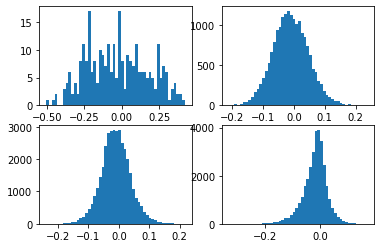

In [40]:
plot_weights(model)

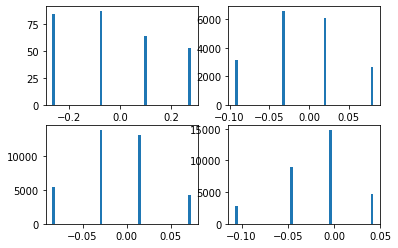

In [41]:
plot_weights(quant_model)